## Zadanie 6: Gaz neuronowy

Zaimplementuj algorytm gazu neuronowego służącego do kwantyzacji wektorowej. W implementacji możesz wykorzystać klasę ``VectorQuantization`` z pliku [vq.py](vq.py) i oraz implementację kwantyzacji wektorowej z ćwiczeń, wówczas rozwiązanie sprowadza się do przeciążenia metody ``fit()``. 

**Parametry początkowe** (ustawiane w argumentach konstruktora):

* $N$ liczba epok
* $k$ liczba neuronów (prototypów)
* $\eta_0$ początkowa wartość kroku uczenia
* $\lambda_0$ początkowa wartość promienia sąsiedztwa
* $\eta_{min}$ końcowa wartość kroku uczenia
* $\lambda_{min}$ końcowa wartość promienia sąsiedztwa

**Algorytm gazu neuronowego**  

1. Zainicjuj wagi $\mathbf{w}_i$ neuronów  (pozycje prototypów)
2. Ustaw $t=0$ oraz $T$ równe całkowitej liczbie iteracji (iloczyn liczby epok $N$ i liczby przypadków uczących)
3. Powtarzaj $N$ razy:
4. <ul>Dla każdego przypadku $\mathbf{x}$ ze zbioru uczącego wykonaj</ul>
5. <ul><ul>wyznacz aktualny współczynnik uczenia <br> $\eta(t)=\eta_0\left(\frac{\eta_{\min }}{\eta_0}\right)^{\frac{t}{T}}$
    </ul></ul>
6. <ul><ul>wyznacz aktualny promień sąsiedztwa <br> $\lambda(t)=\lambda_0\left(\frac{\lambda_{\min }}{\lambda_0}\right)^{\frac{t}{T}}$
    </ul></ul>
7. <ul><ul>uporządkuj neurony względem odległości od $\mathbf{x}$ (<i> wskazówka: kolejność prototypów można uzyskać funkcją <a href="https://numpy.org/doc/stable/reference/generated/numpy.argsort.html">numpy.argsort</a> </i>)</ul></ul>  
8. <ul><ul>zaktualizuj wagi <br> 
   $\mathbf{w}_{i} \leftarrow \mathbf{w}_{i} + \eta(t) \cdot h_i(t) \cdot \left(\mathbf{x}-\mathbf{w}_i\right)\,$<br> gdzie $\, h_i(t)=e^{-\frac{m(i)}{\lambda(t)}}$, zaś 
   $\, m(i) = 0, 1, \ldots, k-1$ oznacza pozycję neuronu $\mathbf{w}_i$ w rankingu odległości od najbliższego do najdalszego
    </ul></ul>
1. <ul><ul>zwiększ $t = t + 1$</ul></ul>

Wykorzystaj algorytm gazu neuronowego do kompresji obrazu [dane/Lenna.png](dane/Lenna.png). Do przygotowania zbioru uczącego możesz wykorzystać funkcje ``img_to_vectors`` oraz ``vectors_to_image`` dostępne w pliku [utils.py](utils.py)  
Spróbuj dobrać parametry modelu gazu neuronowego tak aby uzyskać jak najmniejszy błąd rekonstrukcji przy jak najmniejszym rozmiarze księgi kodów (liczby prototypów). 

### Implementacja gazu neuronowego

In [1]:
from vq import VectorQuantization, square_euclid
import numpy as np

class NeuralGas(VectorQuantization):
    def __init__(self, n_epochs=10, n_prototypes=10,
                 eta_0=1e-1, lambda_0=1e-1,
                 eta_min=1e-4, lambda_min=1e-4):
        self.n_epochs = n_epochs
        self.n_prototypes = n_prototypes
        self.eta_0 = eta_0
        self.lambda_0 = lambda_0
        self.eta_min = eta_min
        self.lambda_min = lambda_min

    def init_prototypes(self, X):
        # ustawia początkową pozycję prototypów

        rng = np.random.default_rng()
        self.prototypes = rng.permutation(X)[:self.n_prototypes]
        return self

    def find_nearest_prototype(self, x):
        # zwraca indeks najbliższego prototypu do x
           
        dist = square_euclid(x, self.prototypes)       
        return np.argmin(dist)

    def fit(self, X):
        # algorytm uczenia gazu neuronowego

        self.init_prototypes(X)
        t = 0
        T = self.n_epochs * X.shape[0]

        self.errors = [self.score(X)]
        rng = np.random.default_rng()

        for _ in range(self.n_epochs):
            for x in rng.permutation(X):
                eta_t = self.eta_0 * (self.eta_min / self.eta_0) ** (t / T)
                lambda_t = self.lambda_0 * (self.lambda_min / self.lambda_0) ** (t / T)

                dist = square_euclid(x, self.prototypes)
                order = np.argsort(np.argsort(dist))
                h_t = np.exp(order / -lambda_t)[:, np.newaxis]
                self.prototypes += eta_t * h_t * (x - self.prototypes)

                t += 1
            self.errors.append(self.score(X))
        return self

    def predict(self, X):
        # zwraca wektor indeksów przypisujących wektory z X do prototypów
        
        return np.array([self.find_nearest_prototype(x) for x in X], dtype=np.int32)

    def score(self, X):
        # zwraca miarę dokładności kwantyzacji, średnią odległość od zwycięskich prototypów
        
        error = []
        for x in X:
            dist = square_euclid(x, self.prototypes)
            m = np.argmin(dist)
            error.append(dist[m])
        return np.mean(error)

### Dane wejściowe

Kształt obrazka:  (512, 512, 3)
Typ danych obrazka:  float32
Pierwszy piksel:  [0.8862745  0.5372549  0.49019608]


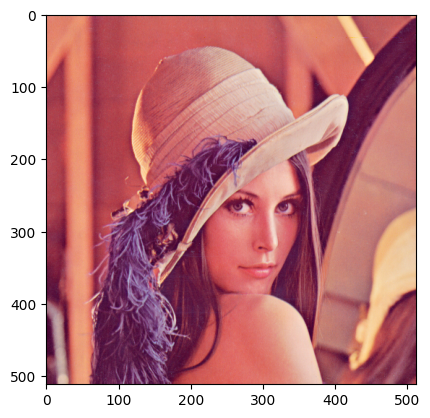

In [2]:
import matplotlib.pyplot as plt

image = plt.imread('dane/Lenna.png')
print("Kształt obrazka: ", image.shape)
print("Typ danych obrazka: ", image.dtype)
print("Pierwszy piksel: ", image[0, 0])
plt.imshow(image)

In [3]:
from utils import img_to_vectors

patch_size = (4, 4)

X = img_to_vectors(image, patch_size=patch_size)
print("Kształt danych x: ", X.shape)

Kształt danych x:  (16384, 48)


### Test

In [4]:
def mse(img1, img2):
    return np.sum(square_euclid(img1, img2))/img1.size

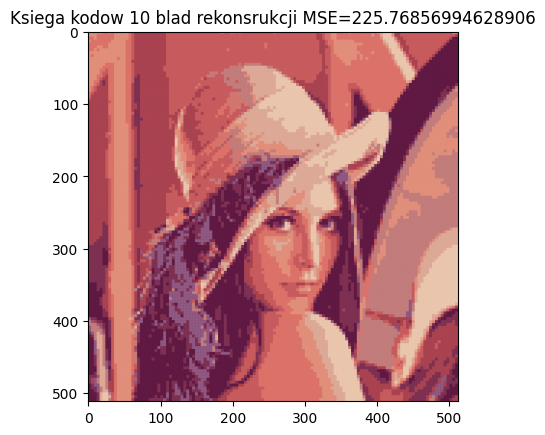

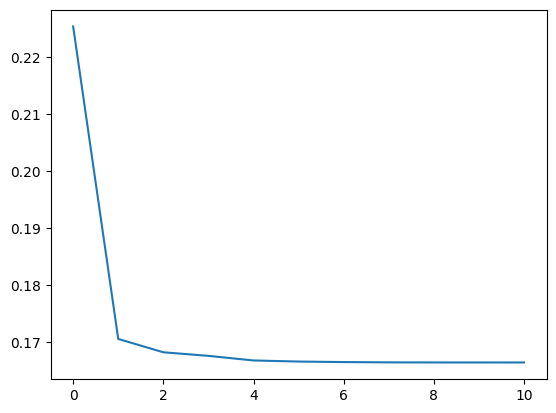

In [5]:
from utils import vectors_to_image

gas = NeuralGas()
gas.fit(X)

pred = gas.predict(X)

restored_image = vectors_to_image(
    gas.prototypes[pred]*255, img_shape=image.shape, patch_size=patch_size)

plt.imshow(restored_image)
plt.title(f'Ksiega kodow {gas.n_prototypes} blad rekonsrukcji MSE={mse(image * 255, restored_image)}')
plt.show()

plt.plot(range(len(gas.errors)), gas.errors)
plt.show()

### Dobranie parametrów

In [6]:
from sklearn.model_selection import ParameterGrid
from time import time
from pandas import DataFrame
from joblib import Parallel, delayed

def evaluate_params(params):
    gas = NeuralGas(**params)
    start_time = time()
    gas.fit(X)
    fit_time = time() - start_time
    start_time = time()
    score = gas.score(X)
    score_time = time() - start_time
    return {
        **params,
        'params': params,
        'error': score,
        'fit_time': fit_time,
        'score_time': score_time,
        'model': gas
    }

def grid_search(param_grid, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_params)(params) for params in ParameterGrid(param_grid)
    )

    models = [result.pop('model') for result in results]
    results_df = DataFrame(results)

    results_df['rank'] = results_df['error'].rank(ascending=True).astype(int)
    top_idx = results_df[results_df['rank'] == 1].index[0]
    print(top_idx)

    best_model = models[top_idx]
    best_score = results_df.loc[top_idx, 'error']
    best_params = results_df.loc[top_idx, 'params']

    return {
        'results_df': results_df,
        'best_error': best_score,
        'best_params': best_params,
        'best_model': best_model
    }

2
Najlepszy wynik (najniższy błąd): 0.11235317
Najlepsze parametry:  {'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 1.0, 'lambda_min': 1e-05, 'n_epochs': 5, 'n_prototypes': 25}


,eta_0,eta_min,lambda_0,lambda_min,n_epochs,n_prototypes,params,error,fit_time,score_time,rank
0,1.00,0.00100,1.00,0.00100,5,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 1...",0.112779,6.159569,0.313037,4
1,1.00,0.00100,1.00,0.00100,10,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 1...",0.112977,10.628058,0.289733,5
2,1.00,0.00100,1.00,0.00001,5,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 1...",0.112353,5.640357,0.395374,1
3,1.00,0.00100,1.00,0.00001,10,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 1...",0.113540,10.651841,0.301084,9
4,1.00,0.00100,0.01,0.00100,5,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 0...",0.115279,5.465653,0.490640,18
5,1.00,0.00100,0.01,0.00100,10,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 0...",0.114665,11.491431,0.304504,15
6,1.00,0.00100,0.01,0.00001,5,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 0...",0.114653,6.532023,0.332656,14
7,1.00,0.00100,0.01,0.00001,10,25,"{'eta_0': 1.0, 'eta_min': 0.001, 'lambda_0': 0...",0.114667,10.670788,0.297042,16
8,1.00,0.00001,1.00,0.00100,5,25,"{'eta_0': 1.0, 'eta_min': 1e-05, 'lambda_0': 1...",0.112662,5.445578,0.465761,3
9,1.00,0.00001,1.00,0.00100,10,25,"{'eta_0': 1.0, 'eta_min': 1e-05, 'lambda_0': 1...",0.113288,11.355938,0.290630,7


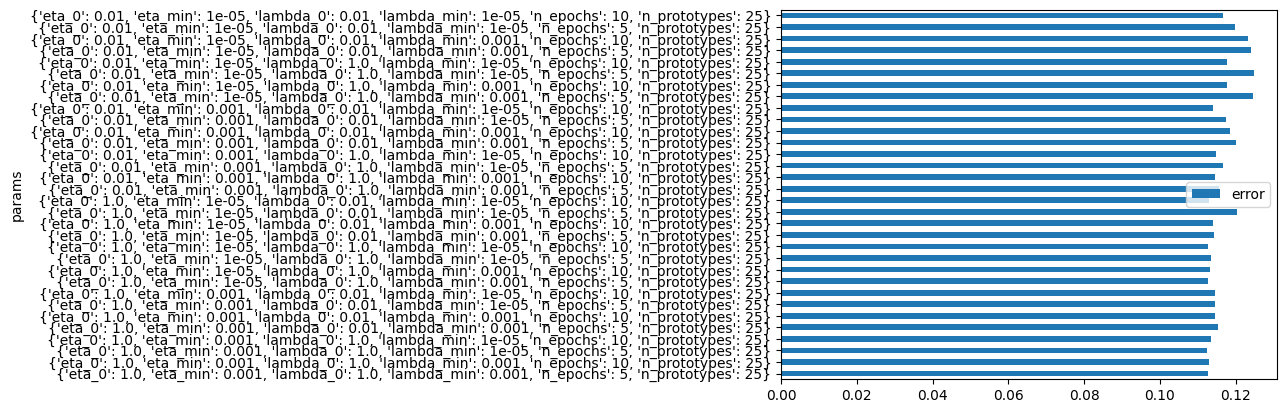

In [7]:
param_grid = {
    'n_epochs': [ 5, 10 ],
    'n_prototypes': [ 25 ],
    'eta_0': [1e0, 1e-2],
    'eta_min': [1e-3, 1e-5],
    'lambda_0': [1e0, 1e-2],
    'lambda_min': [1e-3, 1e-5]
}
gs = grid_search(param_grid=param_grid, n_jobs=-1)
print("Najlepszy wynik (najniższy błąd):", gs['best_error'])
print("Najlepsze parametry: ", gs['best_params'])

df = gs['results_df']
df.plot.barh(x='params', y='error')
df

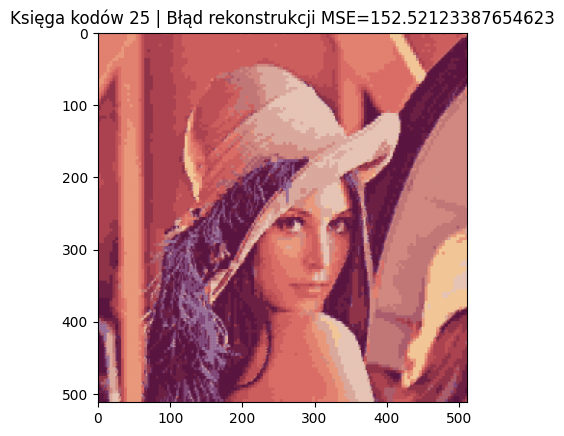

In [8]:
gas = gs['best_model']

pred = gas.predict(X)

restored_image = vectors_to_image(
    gas.prototypes[pred]*255, img_shape=image.shape, patch_size=patch_size)

plt.imshow(restored_image)
plt.title(f'Księga kodów {gas.n_prototypes} | Błąd rekonstrukcji MSE={mse(image * 255, restored_image)}')
plt.show()